# Logistic Regression from Scratch

## The problem

We have to find the parameters that best describe the relationship between neural features and the trail class. The space of possible parameters is infinite, and we want an approach to find them that is general enough to work with any data set we throw at it. One way is to randomly guess the parameters, and to keep guessing until we get a good fit. Here are some random guesses:


In [68]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [69]:
# load data from last week
data_dir = '../Week4/data/'

# load data
X = np.load(os.path.join(data_dir, 'X.npy'))
y = np.load(os.path.join(data_dir, 'y.npy'))

# load fitted parameters
params = json.load(open(os.path.join(data_dir, 'model_params.json'), 'r'))

In [92]:
params['coef']

0.05187913417506095

In [96]:
def logistic(x, w, b):
    return 1 / (1 + np.exp(-(w*x + b)))

def plot_logistic(X_vals, y_vals, w, b, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(X_vals, y_vals, alpha=0.5)
    x = np.linspace(np.min(X_vals), np.max(X_vals), 100)
    ax.plot(x, logistic(x, w, b), 'r')
    ax.grid()
    return ax

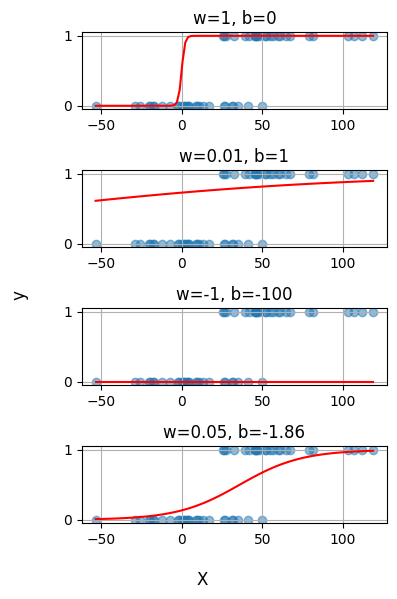

In [97]:
fig, ax = plt.subplots(4,1, figsize=(4,6))

plot_logistic(X, y, 1, 0, ax=ax[0])
ax[0].set_title('w=1, b=0')
plot_logistic(X, y, 0.01, 1, ax=ax[1])
ax[1].set_title('w=0.01, b=1')
plot_logistic(X, y, -1, -100, ax=ax[2])
ax[2].set_title('w=-1, b=-100')
plot_logistic(X, y, params['coef'], params['intercept'], ax=ax[3])
ax[3].set_title('w={:.2f}, b={:.2f}'.format(params['coef'], params['intercept']))
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()

Those don't look too good! While it may be tempting to keep trying different combinations of `w` and `b` to get a better fit, that would be a poor use of our time. Moreover, we would have to go through the same process for each new data set we work with.

Instead, perhaps we could start with a random choice, and then iteratively update our parameters to try and get a better fit. At each update, we want to move the parameters so the fit gets better. But how do we measure if the fit is better? For this we will introduce the notion of a *loss function*.

## Loss function
The loss function reflects the difference between the actual class, $y$, and the predicted probability of that class,  $\hat{y}$. The lower value it has, the better the fit. To start building this function, let's consider the probability of $y$ given our prediction, $\hat{y}$, expressed as $p(y|\hat{y})$. Since $y$ is a binary variable (i.e. Cue or NoCue), we can express the probability as a Bernoulli distribution:

$$ p(y|\hat{y}) = \hat{y}^y(1-\hat{y})^{1-y} \tag{1}$$

Note that if $y=1$, we just return $\hat{y}$, because:

$$ \begin{align} 
    \notag p(1|\hat{y}) &= \hat{y}^1(1-\hat{y})^{1-1}  \\
    \notag &= \hat{y}^1(1-\hat{y})^{0} \\ 
    \notag &= \hat{y}^1\times 1 \\
    \notag &= \hat{y}
    \end{align}
$$


and if $y=0$, then $1-\hat{y}$ is returned:
$$ \begin{align} 
    \notag p(0|\hat{y}) &= \hat{y}^0(1-\hat{y})^{1-0}  \\
    \notag &= 1\times(1-\hat{y})^{1} \\ 
    \notag &= 1-\hat{y}
    \end{align}
$$

Alternatively, it might make more sense to you if we express equation 1 as a piecewise function.
$$ p(y|\hat{y})=\begin{cases}
    \hat{y} & y=1 \\
    1-\hat{y} & y=0
    \end{cases}
$$

Each possiblity is represented as a different case enclosed by the large bracket. Here y=1 when a cue occurs, and y=0 when no cue is present. If a cue occured, then we return the probability of the cue, $\hat{y}$. If no cue occured, then we return the probability that no cue occured, $1-\hat{y}$. 

How does equation 1 behave depending on $y$ and $\hat{y}$?

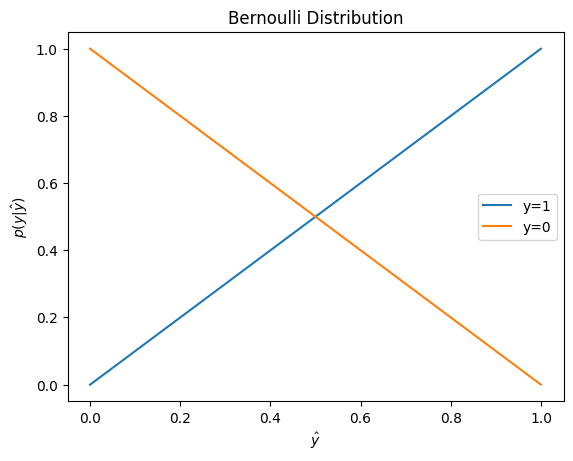

In [98]:
def bernoulli_dist(y, y_hat):
    return np.power(y_hat, y) * np.power(1-y_hat,1-y)

y_hat = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(y_hat, bernoulli_dist(1, y_hat), label='y=1')
ax.plot(y_hat, bernoulli_dist(0, y_hat), label='y=0')
ax.set_xlabel(r'$\hat{y}$')
ax.set_ylabel(r'$p(y|\hat{y})$')
ax.set_title('Bernoulli Distribution')
ax.legend()
plt.show()

If we fit a model successfully so that it correctly predicts $y$, then trials with a cue ($y=1$) will return high values of $\hat{y}$. Correctly predicting no cue ($y=0$), will give high values as well since $1-\hat{y}$ is returned. Consequently, a model with good performance will on average give larger values for $p(y|\hat{y})$. To visualize this, we can add arrows to our logistic regression graph that represent the output of this function for each sample.

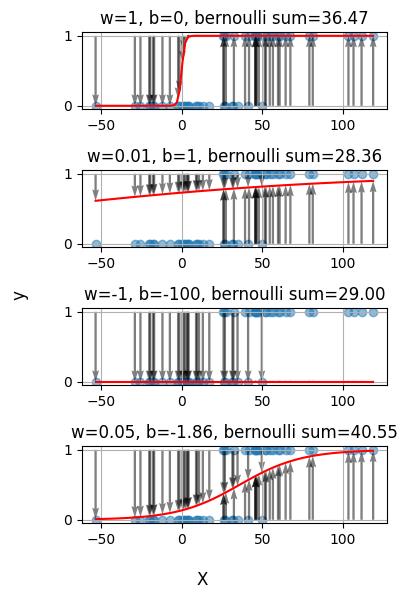

In [100]:
def plot_logistic_wloss(X_vals, y_vals, w, b, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax = plot_logistic(X_vals, y_vals, w, b, ax=ax)

    sign_y = np.sign(y_vals - 0.5)

    bern_vals = bernoulli_dist(y_vals, logistic(X_vals.squeeze(), w, b))
    ax.quiver(X_vals, 1-y_vals, np.zeros(y_vals.size), 
              sign_y*bern_vals, angles='xy', scale_units='xy', scale=1, alpha=0.5)
    return ax, np.sum(bern_vals)

fig, ax = plt.subplots(4,1, figsize=(4,6))

_, bern_sum = plot_logistic_wloss(X, y, 1, 0, ax=ax[0])
ax[0].set_title('w=1, b=0, bernoulli sum={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_wloss(X, y, 0.01, 1, ax=ax[1])
ax[1].set_title('w=0.01, b=1, bernoulli sum={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_wloss(X, y, -1, -100, ax=ax[2])
ax[2].set_title('w=-1, b=-100, bernoulli sum={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_wloss(X, y, params['coef'], params['intercept'], ax=ax[3])
ax[3].set_title('w={:.2f}, b={:.2f}, bernoulli sum={:.2f}'.format(params['coef'], params['intercept'], bern_sum))
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()


The best fitted one, at the top, has the highest total Bernoulli sum. This is because it has more of its Cue trials on the high probability side, and NoCue trials on the low probability site. The second example is similar, but the logistic function is so broad that the expected probabilities, $\hat{y}$, are never close to 0 or 1. Worst of all is the last example, with the smallest Bernoulli sum and 

In [87]:
y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

7.53467314304849


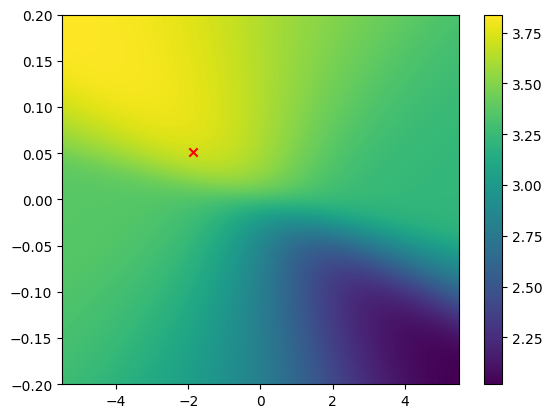

In [107]:
w_grid = np.linspace(-0.2, 0.2, 500)
b_grid = np.linspace(-5.5, 5.5, 500)
b_sum = np.zeros((w_grid.size, b_grid.size))
for i, w in enumerate(w_grid):
    for j, b in enumerate(b_grid):
        b_sum[i,j] = np.sum(bernoulli_dist(y, logistic(X.squeeze(), w, b)))

print(np.min(b_sum.flatten()))
fig, ax = plt.subplots()
#ax.plot(b_sum[90,:])
#ax.plot(b_sum[99,:])

# imshow with w_grid, b_grid and b_sum
im = ax.imshow(np.log(b_sum), extent=[b_grid[0], b_grid[-1], w_grid[0], w_grid[-1]], aspect='auto', origin='lower')
ax.scatter(params['intercept'], params['coef'], marker='x', color='r')
# add colorbar
fig.colorbar(im, ax=ax)


BERNOULLI DISTRIBUTION

OPTIMIZATION/FITTING

LOSS FUNCTION

BINARY CROSS ENTROPY LOSS FUNCTION

DERIVATIVE OF LOSS FUNCTION

GRADIENT DESCENT


/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/2771818357.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x), label='log(x)')


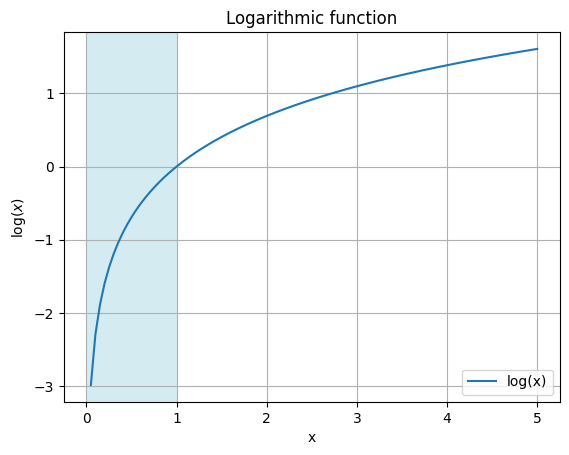

In [16]:
x = np.linspace(0, 5, 100)

plt.plot(x, np.log(x), label='log(x)')
plt.xlabel('x')
plt.ylabel('$\log(x)$')
plt.title('Logarithmic function')
plt.grid()
plt.axvspan(0, 1, facecolor='lightblue', alpha=0.5)
plt.legend()


1. $\log(xy) = \log(x) + \log(y)$
2. $\log\left(\frac{x}{y}\right) = \log(x) - \log(y)$
3. $\log(x^n) = n\log(x)$
4. $\log(1) = 0$
5. $\log(0) = -\inf$

$$ \log(p(y|x))=y\log(\hat{y})+(1-y)\log(1-\hat{y})$$

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/854167381.py:2: RuntimeWarning: divide by zero encountered in log
  return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/854167381.py:2: RuntimeWarning: invalid value encountered in multiply
  return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


Text(0.5, 1.0, 'Log Loss')

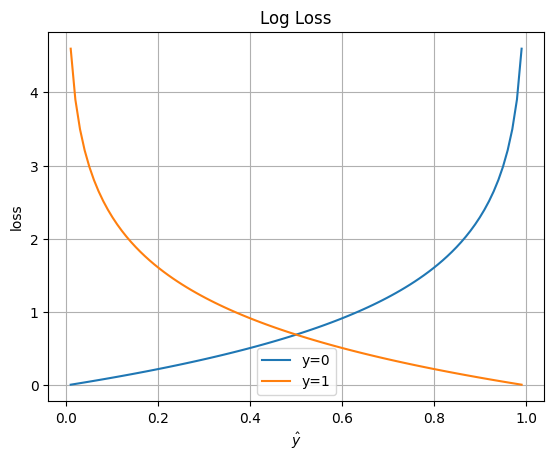

In [19]:
def loss_log(y, y_hat):
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))

x = np.linspace(0, 1, 100)

plt.plot(x, loss_log(0, x), label='y=0')
plt.plot(x, loss_log(1, x), label='y=1')
plt.legend()
plt.grid()
plt.xlabel('$\hat{y}$')
plt.ylabel('loss')
plt.title('Log Loss')


$$ \begin{align}
    \notag \frac{\partial{L}}{\partial{w}}&=\frac{\partial}{\partial{w}}-(y\log(\sigma(wx+b))+(1-y)\log(1-\sigma(wx+b)))\\
    \notag &=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{w}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{w}}1-\sigma(wx+b)\right)\right) \\
    \notag &=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{w}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{w}}-\sigma(wx+b)\right)\right) \\
    \notag &=-\left(\frac{y}{\sigma(wx+b)}-\frac{1-y}{1-\sigma(wx+b)}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y(1-\sigma(wx+b))}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{(1-y)\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{\sigma(wx+b)-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))\frac{\partial}{\partial{w}}(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))x \\
    \notag &=-(y-\sigma(wx+b))x \\
    \notag &= (\sigma(wx+b)-y)x \\
\end{align}
$$

$$ \begin{align}
    \notag \textcolor{lightgray}{\frac{\partial{L}}{\partial{b}}}&\textcolor{lightgray}{=\frac{\partial}{\partial{b}}-(y\log(\sigma(wx+b))+(1-y)\log(1-\sigma(wx+b)))}\\
    \notag &\textcolor{lightgray}{=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{b}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{b}}1-\sigma(wx+b)\right)\right)} \\
    \notag &\textcolor{lightgray}{=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{b}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{b}}-\sigma(wx+b)\right)\right)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y}{\sigma(wx+b)}-\frac{1-y}{1-\sigma(wx+b)}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y(1-\sigma(wx+b))}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{(1-y)\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{\sigma(wx+b)-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))}\frac{\partial}{\partial{b}}(wx+b) \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))} \cdot 1 \\
    \notag &=-(y-\sigma(wx+b)) \\
    \notag &= \sigma(wx+b)-y \\
\end{align}
$$

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/3150900135.py:2: RuntimeWarning: divide by zero encountered in log
  return y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/3150900135.py:2: RuntimeWarning: invalid value encountered in multiply
  return y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)


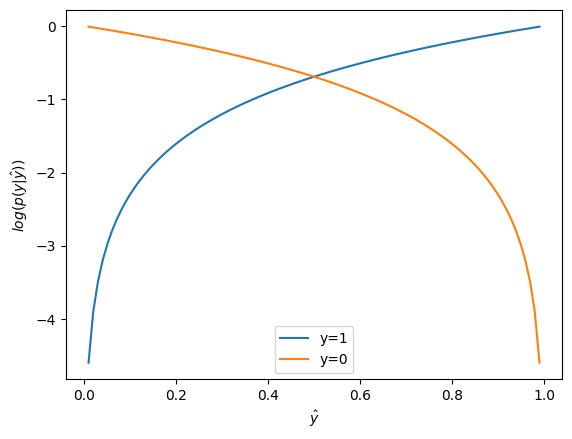

In [7]:
def log_bernoulli_dist(y, y_hat):
    return y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)

y_hat = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(y_hat, log_bernoulli_dist(1, y_hat), label='y=1')
ax.plot(y_hat, log_bernoulli_dist(0, y_hat), label='y=0')
ax.set_xlabel(r'$\hat{y}$')
ax.set_ylabel(r'$log(p(y|\hat{y}))$')
ax.legend()
plt.show()